In [18]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math

M0 = 1480 #mT
shape = [3*25.4/16, 25.4/8] #radius and height
x0 = np.array([0,0,10, 0,0,1])


In [19]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, *args
    ).x  
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res

def circle_radius(x1, y1, x2, y2, x3, y3):
    # Calculate lengths of sides of the triangle formed by the three points
    a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    c = math.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    # Calculate the radius of the circle using the formula: radius = (abc) / (4 * area)
    radius = (a * b * c) / (4 * area)
    
    return radius

In [20]:
folder = r"C:\Users\Brandon Nguyen\Documents\Github\magnetic-sensor-data\MLX05082024_angle_test2"
file_list = sorted(glob.glob(f'{folder}/*.npz'))
len(file_list)
data = np.load(file_list[0])
pos = data['pos'][0]

In [21]:
loc_pred = [np.array([0,0,0])]
angle_pred = [np.array([0,0,0])]
B_stdev = [np.array(pos)]
for x in range(len(file_list)):
    data = np.load(file_list[x])
    mags = data['mags']
    pos = data['pos'][0]
    B = np.mean(mags, axis=0)
    mags_stdev = np.std(mags, axis=0)
    x_res = minimize(x0, B, pos, M0, shape)
    loc_pred = np.append(loc_pred, [x_res[0:3]], axis=0)
    angle_pred = np.append(angle_pred, [x_res[3:6]], axis=0)
    B_stdev = np.append(B_stdev, [mags_stdev], axis=0)
loc_pred = np.delete(loc_pred, 0, axis=0)
angle_pred = np.delete(angle_pred, 0, axis=0)
B_stdev = np.delete(B_stdev, 0 ,axis=0)

In [22]:
np.append(loc_pred, angle_pred, axis=1)
#np.sum(angle_pred**2)

array([[-1.65700525e-01, -1.06566412e-01,  1.00505388e+01,
        -1.68150777e-01, -1.44238380e-01,  9.75151581e-01],
       [-1.57472965e-01,  2.16472094e-02,  1.00505058e+01,
        -1.69474958e-01, -1.43912107e-02,  9.85429415e-01],
       [-1.37014778e-01,  1.37325089e-01,  1.00333281e+01,
        -1.66091779e-01,  1.11132669e-01,  9.79828072e-01],
       [-1.91510699e-02, -1.09619805e-01,  1.01062552e+01,
        -5.67517569e-02, -1.45751304e-01,  9.87692156e-01],
       [-5.14308919e-02,  3.53570795e-02,  1.01040641e+01,
        -5.24173120e-02, -8.92370053e-03,  9.98585396e-01],
       [-1.50234698e-02,  1.54362914e-01,  1.00811834e+01,
        -4.85142512e-02,  1.25095457e-01,  9.90957867e-01],
       [ 1.19766359e-01, -9.92391173e-02,  1.01419729e+01,
         7.47796648e-02, -1.37462204e-01,  9.87680183e-01],
       [ 9.98453288e-02,  2.32264996e-02,  1.01389804e+01,
         7.56420715e-02, -8.28545302e-03,  9.97100611e-01],
       [ 9.70086917e-02,  1.78698452e-01,  1.011

In [23]:
actang = [np.array([0, 0, 0])]
for y in range(3):
    for z in range(3):
        add = np.array([np.sin(np.deg2rad(5*y-5)), np.sin(np.deg2rad(5*z-5)), np.cos(np.deg2rad(5*y-5))*np.cos(np.deg2rad(5*z-5))])
        actang = np.append(actang, [add], axis=0)
actang = np.delete(actang, 0, axis=0)
locact = actang
np.sum(actang**2)

9.000230804368536

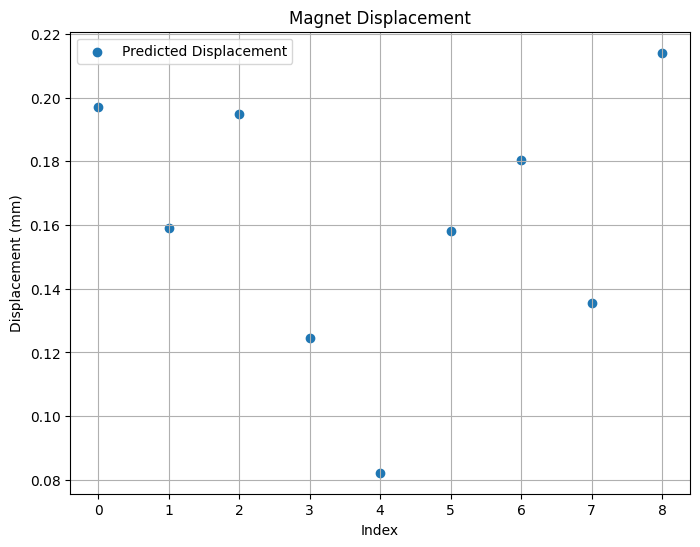

[-0.16570053 -0.15747297 -0.13701478 -0.01915107 -0.05143089 -0.01502347
  0.11976636  0.09984533  0.09700869]
[-0.10656641  0.02164721  0.13732509 -0.1096198   0.03535708  0.15436291
 -0.09923912  0.0232265   0.17869845]
[ 0.00000000e+00 -3.29418621e-05 -1.72106623e-02  5.57163995e-02
  5.35253582e-02  3.06446040e-02  9.14341217e-02  8.84416815e-02
  6.71204085e-02]
[0.19701031 0.15895389 0.19474968 0.12444912 0.08222058 0.15809081
 0.18042334 0.13539014 0.21412373]


In [24]:
dispx = np.array(loc_pred[:,0])
dispy = np.array(loc_pred[:,1])
dispz = np.array(loc_pred[:,2]-loc_pred[:,2][0])
disp = np.sqrt(dispx**2+dispy**2+dispz**2)

plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predx))), disp, label='Predicted Displacement')
plt.xlabel('Index')
plt.ylabel('Displacement (mm)')
plt.title('Magnet Displacement')
plt.legend()
plt.grid(True)
plt.show()

print(dispx)
print(dispy)
print(dispz)
print(disp)

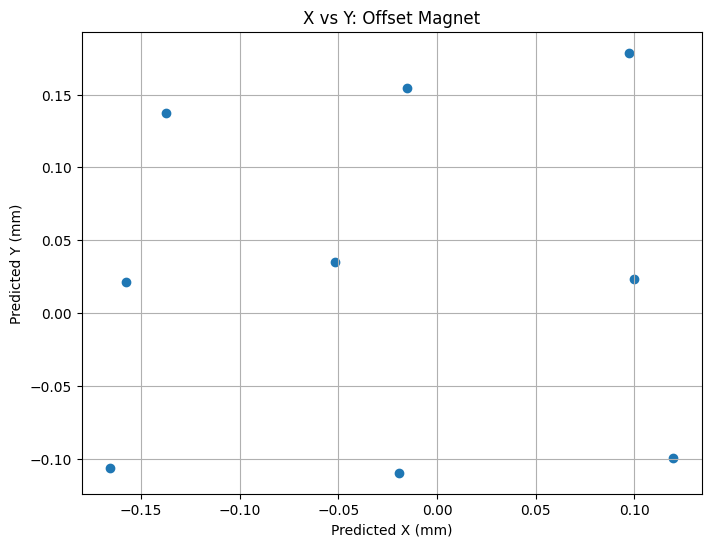

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(dispx, dispy, label='Predicted Location')
plt.xlabel('Predicted X (mm)')
plt.ylabel('Predicted Y (mm)')
plt.title('X vs Y: Offset Magnet')
#plt.legend()
plt.grid(True)
plt.show()

In [26]:
x1, z1 = loc_pred[0,0], loc_pred[0,2]
x2, z2 = loc_pred[3,0], loc_pred[1,2]
x3, z3 = loc_pred[6,0], loc_pred[2,2]
print("Radius of the circle about the x-axis:", circle_radius(x1, z1, x2, z2, x3, z3))

y1 = loc_pred[0,1]
y2 = loc_pred[1,1]
y3 = loc_pred[2,1]
print("Radius of the circle about the y-axis:", circle_radius(y1, z1, y2, z2, y3, z3))

Radius of the circle about the x-axis: 1.167320583488788
Radius of the circle about the y-axis: 0.8337166861003524


Make another angle measurement with magnet offset, plot x vs y to see if there is a circular plot.
Finish gamma knife data analysis
Check inventory for stencil stuff.